## APSIM Next Gen Sorghum Validation using vegetation index data

In [2]:
################################################################################################################
# Developed by Jonathan Ojeda 9/2/2021 QAAFI-UQ
# Code functionalities:
# Compare model simulations with S2 imagery
#################################################################################################################

In [1]:
import os
import sqlite3
import datetime
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [46]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [101]:
#Read the data for the scatter plot
dfS2=pd.read_csv(r'C:\Users\uqjojeda\Dropbox\CropPhen\APSIM-files\Observed.csv')

#Read data from APSIM
con = sqlite3.connect(r'C:\Users\uqjojeda\Dropbox\CropPhen\APSIM-files\SorghumV2.db')
daily = pd.read_sql("Select * from DailyReport",con)
daily['Biomass_APSIM'] = daily['Sorghum.AboveGround.Wt']*10/1000

#Read the Simulations table that has SimulationID matched to Simulation Name
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
#Add SimulationName column
daily.loc[:,'SimulationName'] = [Simulations.loc[daily.loc[x,'SimulationID'],'Name'] for x in daily.index]
daily.set_index('SimulationID',inplace=True)
daily.drop_duplicates(inplace=True)

#Merge observed and simulated datasets
df = daily.merge(dfS2, on=['Das','SimulationName'], how = 'outer')
#df.to_csv(r'C:\Users\uqjojeda\Dropbox\CropPhen\Python\df.csv')
df.rename(columns={'Leaf.CoverGreen':'Cover_APSIM','CoverGreen_OBS':'Cover_S2','SimulationName':'SN','Leaf.LAI':'LAI_APSIM',
                   'Sorghum.Phenology.Stage':'stage_sim','Sorghum.Phenology.CurrentPhaseName':'phase_sim',
                   'Sorghum.Phenology.AccumulatedTT':'TT'}, inplace=True)
#df['TTCum'] = df['TT'].cumsum()

In [45]:
# par = df[df['fPAR'].notna()]
# osavi = df[df['OSAVI'].notna()]

# colors=['#F0FF00','#33FF00','#66717B','#00B4FF','#FF0027','#CA00FF', 'pink']
# kwargs  =   {'edgecolor':"k"}
# fig= plt.figure(figsize=(6,8))
# ax=plt.subplot(2, 1, 1)
# ax=sns.scatterplot(x='Das', y='fPAR', hue='SN', data=par, alpha=0.8, linestyle='-', linewidth=0.5, s=200, **kwargs, palette=colors)
# plt.legend(prop=dict(size=15),bbox_to_anchor=(1.1,0.9), loc=2, borderaxespad=0., frameon=False)
# ax=plt.subplot(2, 1, 2)
# ax=sns.scatterplot(x='Das', y='OSAVI', hue='SN', data=osavi, alpha=0.8, linestyle='-', linewidth=0.5, s=200, **kwargs, palette=colors)
# plt.legend(prop=dict(size=15),bbox_to_anchor=(1.1,0.9), loc=2, borderaxespad=0., frameon=False)
# hide_toggle()

## Plotting timeseries data: vegetation index vs APSIM (3 cultivars * 2 reps)

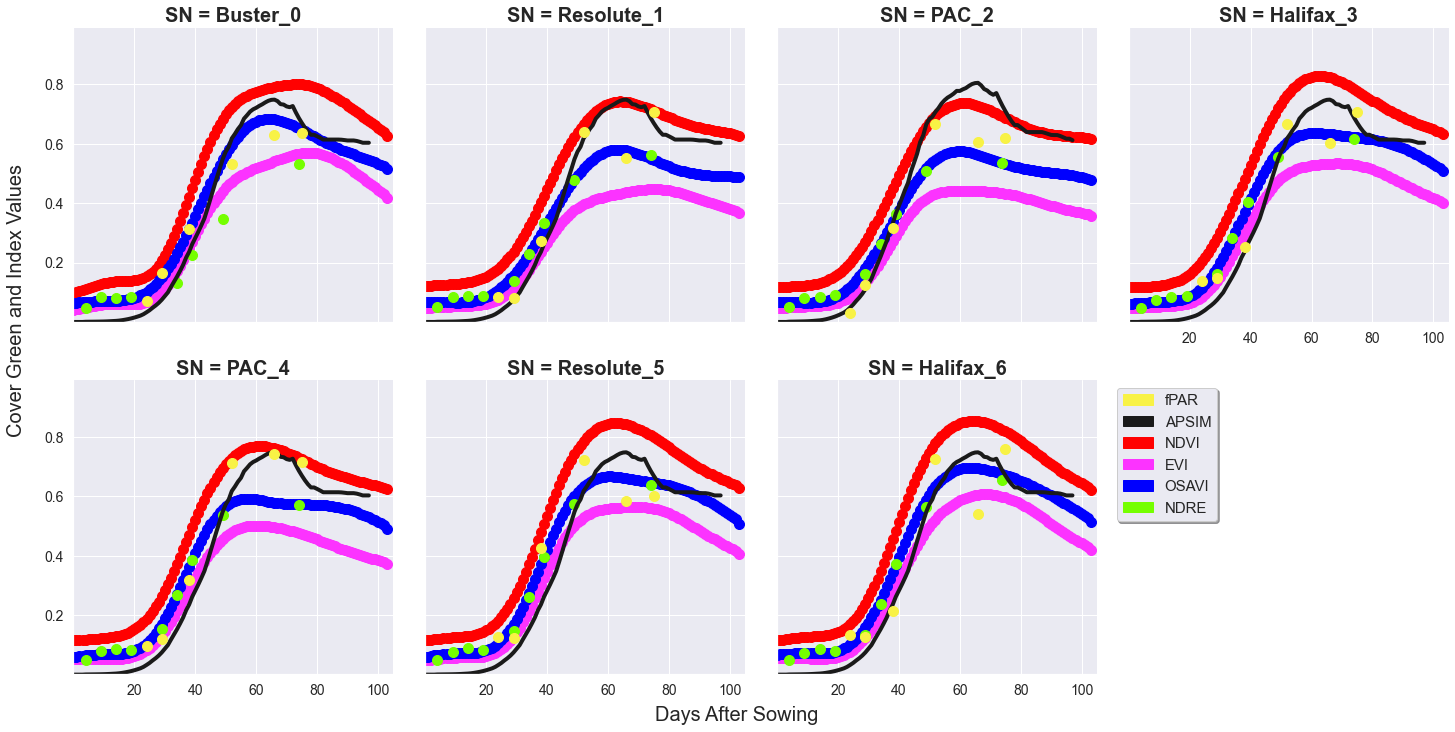

In [111]:
#########################################################################################################################################
sns.set(font_scale=1)
g = sns.FacetGrid(df, col="SN", col_wrap=4, height=5, col_order=['Buster_0','Resolute_1', 'PAC_2','Halifax_3','PAC_4','Resolute_5','Halifax_6'])

#Vegetation index data
#ax = g.map(plt.errorbar, "Das", "Cover_S2", "CoverGreen_OBSError", fmt ='o',marker='',zorder=1,color='#ff0101',linewidth=0.8)
g.map(plt.plot, "Das", "NDVI", linestyle="",linewidth=2,color='#ff0101',marker='o',markersize=10)
g.map(plt.plot, "Das", "EVI", linestyle="",linewidth=2,color='#FC33FF',marker='o',markersize=10)
g.map(plt.plot, "Das", "OSAVI", linestyle="",linewidth=2,color='#0000fe',marker='o',markersize=10)
g.map(plt.plot, "Das", "NDRE", linestyle="",linewidth=2,color='#75FF00',marker='o',markersize=10)

#APSIM data
g.map(plt.plot, "Das", "Cover_APSIM", linestyle="-",linewidth=4,color='k')
g.map(plt.plot, "Das", "fPAR",marker='o',markersize=10,color='#F8F245')

#Legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='#ff0101', label='NDVI')
magenta_patch = mpatches.Patch(color='#FC33FF', label='EVI')
blue_patch = mpatches.Patch(color='#0000fe', label='OSAVI')
green_patch = mpatches.Patch(color='#75FF00', label='NDRE')
yellow_patch = mpatches.Patch(color='#F8F245', label='fPAR')
black_patch = mpatches.Patch(color='k', label='APSIM')

plt.legend(handles=[yellow_patch, black_patch, red_patch, magenta_patch, blue_patch, green_patch],
           bbox_to_anchor=(1.4, 1.0), fancybox=True, shadow=True, ncol=1, fontsize=15)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=20, fontweight="bold")
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,105])
    ax.set_ylim([0.001,0.99])

g.fig.text(-0.01, 0.4,'Cover Green and Index Values', fontsize=20, rotation=90)
g.fig.text(0.44, 0,'Days After Sowing', fontsize=20)
g.fig.text(0.9, 1,'', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.2)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\timeseries.png', dpi=300,bbox_inches='tight')

hide_toggle()

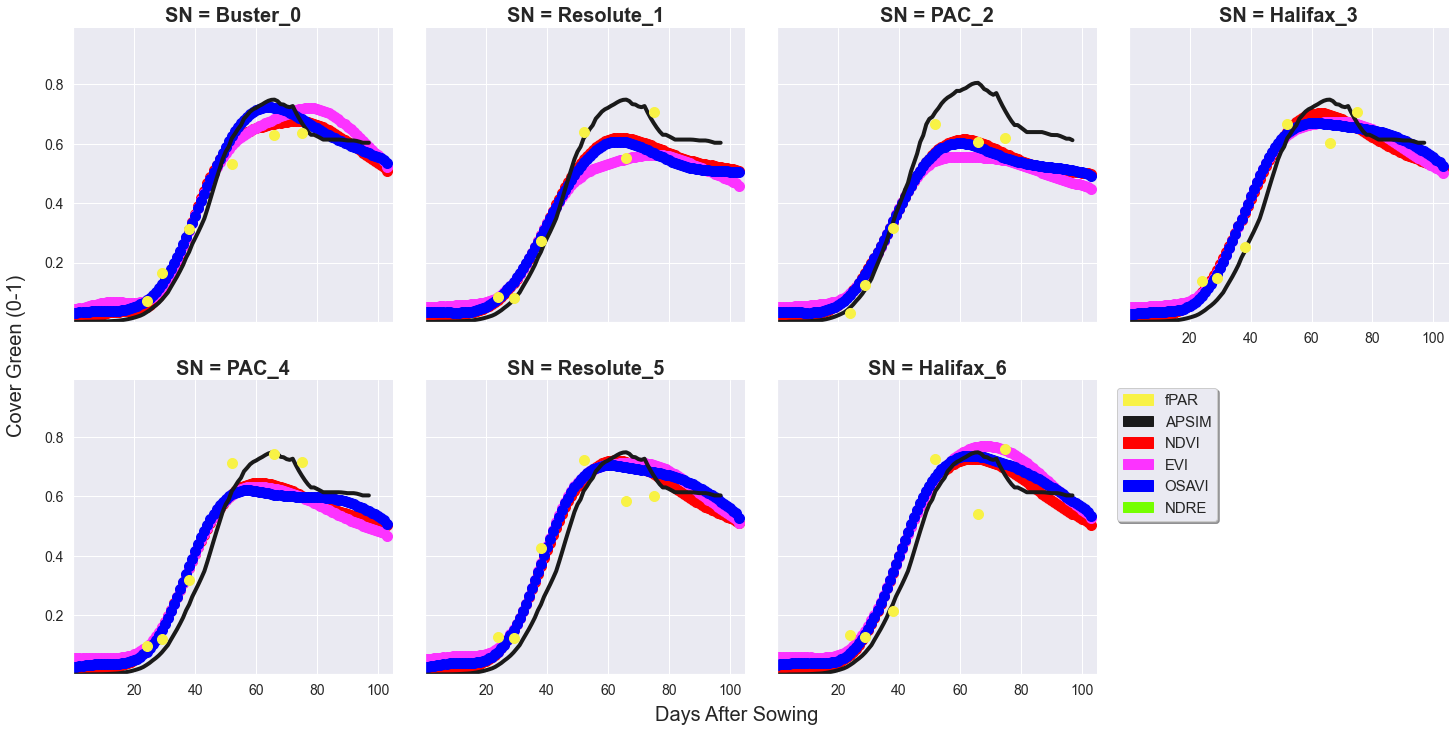

In [118]:
#########################################################################################################################################
sns.set(font_scale=1)
g = sns.FacetGrid(df, col="SN", col_wrap=4, height=5, col_order=['Buster_0','Resolute_1', 'PAC_2','Halifax_3','PAC_4','Resolute_5','Halifax_6'])

#Vegetation index data
#ax = g.map(plt.errorbar, "Das", "Cover_S2", "CoverGreen_OBSError", fmt ='o',marker='',zorder=1,color='#ff0101',linewidth=0.8)
g.map(plt.plot, "Das", "NDVI_CG", linestyle="",linewidth=2,color='#ff0101',marker='o',markersize=10)
g.map(plt.plot, "Das", "EVI_CG", linestyle="",linewidth=2,color='#FC33FF',marker='o',markersize=10)
g.map(plt.plot, "Das", "OSAVI_CG", linestyle="",linewidth=2,color='#0000fe',marker='o',markersize=10)

#APSIM data
g.map(plt.plot, "Das", "Cover_APSIM", linestyle="-",linewidth=4,color='k')
g.map(plt.plot, "Das", "fPAR",marker='o',markersize=10,color='#F8F245')

#Legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='#ff0101', label='NDVI')
magenta_patch = mpatches.Patch(color='#FC33FF', label='EVI')
blue_patch = mpatches.Patch(color='#0000fe', label='OSAVI')
green_patch = mpatches.Patch(color='#75FF00', label='NDRE')
yellow_patch = mpatches.Patch(color='#F8F245', label='fPAR')
black_patch = mpatches.Patch(color='k', label='APSIM')

plt.legend(handles=[yellow_patch, black_patch, red_patch, magenta_patch, blue_patch, green_patch],
           bbox_to_anchor=(1.4, 1.0), fancybox=True, shadow=True, ncol=1, fontsize=15)

# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.set_title(ax.get_title(),fontsize=20, fontweight="bold")
    ax.set_ylabel('', fontsize='medium')
    ax.set_xlabel('', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,105])
    ax.set_ylim([0.001,0.99])

g.fig.text(-0.01, 0.4,'Cover Green (0-1)', fontsize=20, rotation=90)
g.fig.text(0.44, 0,'Days After Sowing', fontsize=20)
g.fig.text(0.9, 1,'', fontsize=25, fontweight="bold")

g.fig.subplots_adjust(wspace=0.1, hspace=.2)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\timeseries2.png', dpi=300,bbox_inches='tight')

hide_toggle()

## Stage vs DAS and Stage vs TT for Buster plot 0

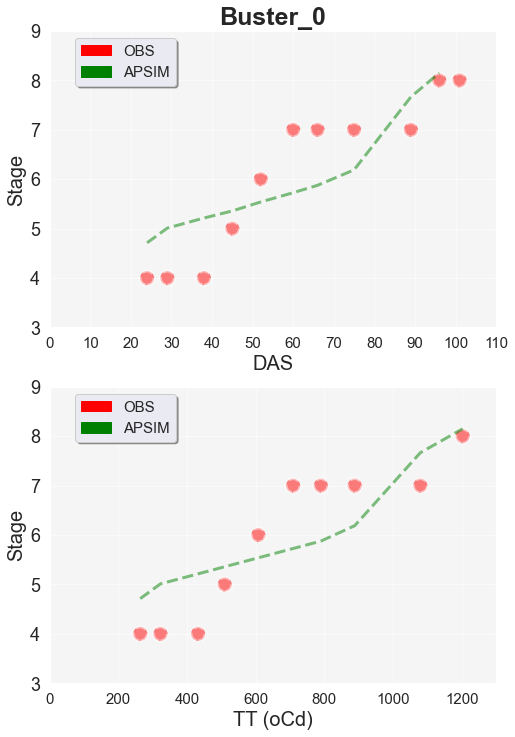

In [90]:
color = ['red']
color2 = ['green']

stage = df[df['stage_OBS'].notna()]
fig= plt.figure(figsize=(8,12))

ax=plt.subplot(2, 1, 1)

ax = sns.scatterplot(x='Das', y='stage_OBS', hue='SN', data=stage, palette=color, alpha=0.5, linestyle='--', linewidth=3, s=200)
ax = sns.lineplot(x='Das', y='stage_sim', hue='SN', data=stage, palette=color2, alpha=0.5, linestyle='--', linewidth=3)
#plt.axvline(x=182.5, color='grey', linestyle='--')
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.1,0.9), loc=2, borderaxespad=0., frameon=False)
plt.ylabel('Stage', fontsize =20)
plt.xlabel('DAS', fontsize =20)
ax = plt.gca()
ax.set_title('Buster_0',fontsize=25, fontweight="bold")
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=15, rotation=0)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_ylim(3,9)
ax.set_xlim(0,110)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_legend().remove()

#Legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='OBS')
green_patch = mpatches.Patch(color='green', label='APSIM')

plt.legend(handles=[red_patch, green_patch],
           bbox_to_anchor=(0.3, 1.0), fancybox=True, shadow=True, ncol=1, fontsize=15)

ax=plt.subplot(2, 1, 2)

ax = sns.scatterplot(x='TT', y='stage_OBS', hue='SN', data=stage, palette=color, alpha=0.5, linestyle='--', linewidth=3, s=200)
ax = sns.lineplot(x='TT', y='stage_sim', hue='SN', data=stage, palette=color2, alpha=0.5, linestyle='--', linewidth=3)
#plt.axvline(x=182.5, color='grey', linestyle='--')
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.1,0.9), loc=2, borderaxespad=0., frameon=False)
plt.ylabel('Stage', fontsize =20)
plt.xlabel('TT (oCd)', fontsize =20)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.xaxis.set_tick_params(labelsize=15, rotation=0)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_ylim(3,9)
ax.set_xlim(0,1300)
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_legend().remove()

#Legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='OBS')
green_patch = mpatches.Patch(color='green', label='APSIM')

plt.legend(handles=[red_patch, green_patch],
           bbox_to_anchor=(0.3, 1.0), fancybox=True, shadow=True, ncol=1, fontsize=15)

#plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\stages.png', dpi=300,bbox_inches='tight')
hide_toggle()

In [103]:
df3 = df[df['Cover_APSIM'].notna()]
df2 = df3.loc[df3['SN'] == 'Buster_0']

thres1=30
thres2=60
df2['Das_Cluster']='30-60'
df2['Das_Cluster'][df2["Das"]<thres1]='0-30'
df2['Das_Cluster'][df2["Das"]>thres2]='60-103'

<ipython-input-103-129dffb45923>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Das_Cluster']='30-60'
<ipython-input-103-129dffb45923>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Das_Cluster'][df2["Das"]<thres1]='0-30'
C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\series.py:990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, in

<ipython-input-113-ebebfda093f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par['Das_Cluster']='30-60'
<ipython-input-113-ebebfda093f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par['Das_Cluster'][par["Das"]<thres1]='0-30'
C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\series.py:990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, in

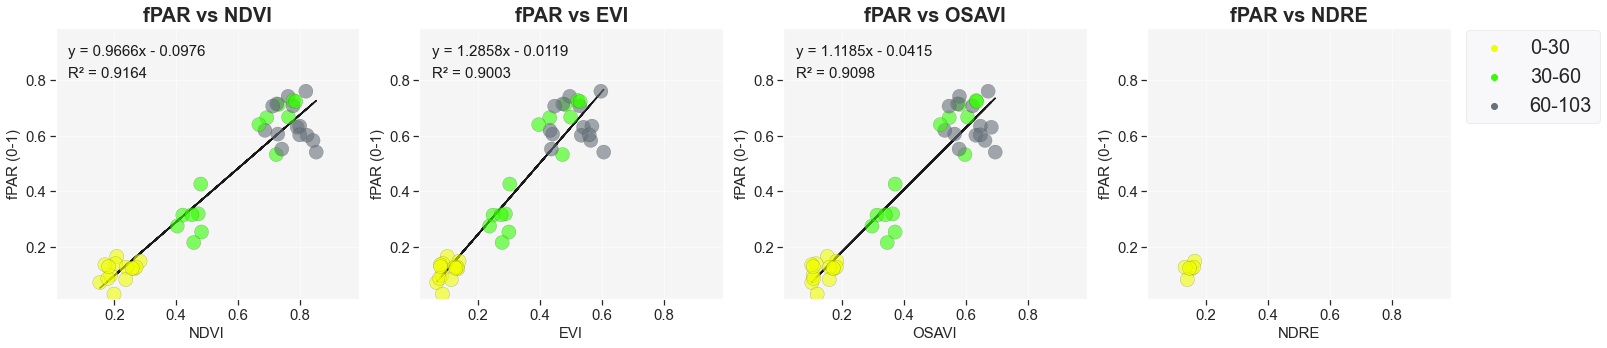

In [113]:
thres1=30
thres2=60
par['Das_Cluster']='30-60'
par['Das_Cluster'][par["Das"]<thres1]='0-30'
par['Das_Cluster'][par["Das"]>thres2]='60-103'

thres1=30
thres2=60
ndre['Das_Cluster']='30-60'
ndre['Das_Cluster'][ndre["Das"]<thres1]='0-30'
ndre['Das_Cluster'][ndre["Das"]>thres2]='60-103'

colors=['#F0FF00','#33FF00','#66717B'] #'#00B4FF','#FF0027','#CA00FF', '#BC45F8'
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(25,5))

################################################################################################
ax=plt.subplot(1, 4, 1)
ax.set_title('fPAR vs NDVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(y="fPAR", x="NDVI",hue='Das_Cluster', alpha=0.6, data=par, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

y=par.fPAR.values
x=par.NDVI.values

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b,color='k')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.xlabel('NDVI', fontsize =15)
plt.ylabel('fPAR (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

plt.text(xmax*0.05, ymax*0.9,'y = 0.9666x - 0.0976', fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'R² = 0.9164', fontsize=15,color='k')
################################################################################################
ax=plt.subplot(1, 4, 2)
ax.set_title('fPAR vs EVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(y="fPAR", x="EVI",hue='Das_Cluster', alpha=0.6, data=par, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

y=par.fPAR.values
x=par.EVI.values

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b,color='k')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.xlabel('EVI', fontsize =15)
plt.ylabel('fPAR (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

plt.text(xmax*0.05, ymax*0.9,'y = 1.2858x - 0.0119', fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'R² = 0.9003', fontsize=15,color='k')
################################################################################################
ax=plt.subplot(1, 4, 3)
ax.set_title('fPAR vs OSAVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(y="fPAR", x="OSAVI",hue='Das_Cluster', alpha=0.6, data=par, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

y=par.fPAR.values
x=par.OSAVI.values

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b,color='k')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.xlabel('OSAVI', fontsize =15)
plt.ylabel('fPAR (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

plt.text(xmax*0.05, ymax*0.9,'y = 1.1185x - 0.0415', fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'R² = 0.9098', fontsize=15,color='k')
################################################################################################
ax=plt.subplot(1, 4, 4)
ax.set_title('fPAR vs NDRE',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(y="fPAR", x="NDRE",hue='Das_Cluster', alpha=0.6, data=ndre, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.xlabel('NDRE', fontsize =15)
plt.ylabel('fPAR (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
plt.legend(prop=dict(size=20),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)

#plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\eq.png', dpi=300,bbox_inches='tight')

## XY plots: vegetation index vs APSIM  (3 cultivars * 2 reps)

<ipython-input-114-d8956a7fc579>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par['Das_Cluster']='30-60'
<ipython-input-114-d8956a7fc579>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par['Das_Cluster'][par["Das"]<thres1]='0-30'
C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\series.py:990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, in

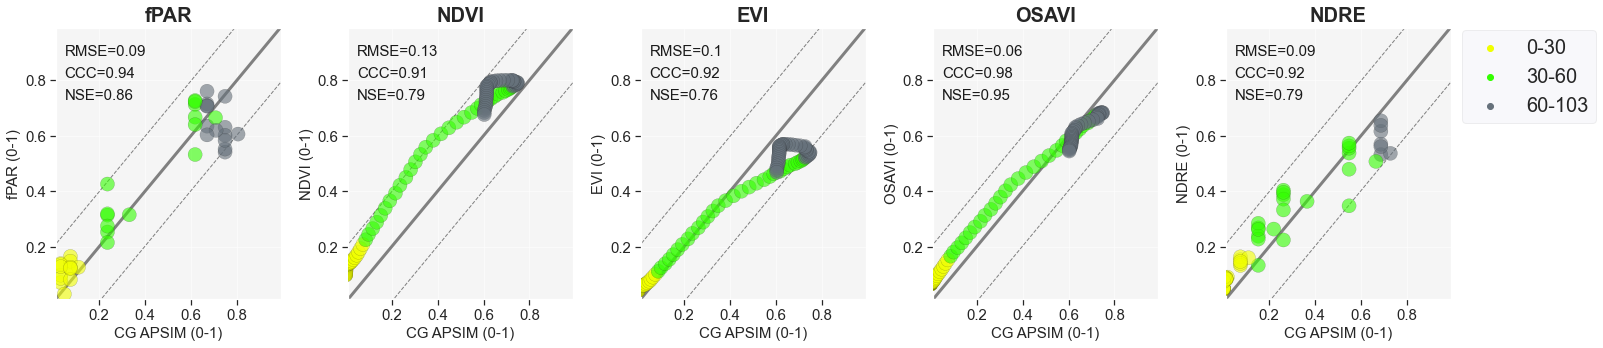

In [114]:
thres1=30
thres2=60
par['Das_Cluster']='30-60'
par['Das_Cluster'][par["Das"]<thres1]='0-30'
par['Das_Cluster'][par["Das"]>thres2]='60-103'
ndre['Das_Cluster']='30-60'
ndre['Das_Cluster'][ndre["Das"]<thres1]='0-30'
ndre['Das_Cluster'][ndre["Das"]>thres2]='60-103'

colors=['#F0FF00','#33FF00','#66717B'] #'#00B4FF','#FF0027','#CA00FF', '#BC45F8'
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(25,5))

################################################################################################
ax=plt.subplot(1, 5, 1)
ax.set_title('fPAR',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="fPAR",hue='Das_Cluster' , alpha=0.6, data=par, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('fPAR (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
par = df[df['fPAR'].notna()]
Obs = pd.Series(par.fPAR.values)
y_o= Obs.tolist()
Pre = pd.Series(par.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

################################################################################################
ax=plt.subplot(1, 5, 2)
ax.set_title('NDVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="NDVI",hue='Das_Cluster' , alpha=0.6, data=df2, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('NDVI (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df2.NDVI.values)
y_o= Obs.tolist()
Pre = pd.Series(df2.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

#########################################################
ax=plt.subplot(1, 5, 3)
ax.set_title('EVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="EVI",hue='Das_Cluster' , alpha=0.6, data=df2, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('EVI (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df2.EVI.values)
y_o= Obs.tolist()
Pre = pd.Series(df2.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')


#########################################################
ax=plt.subplot(1, 5, 4)
ax.set_title('OSAVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="OSAVI",hue='Das_Cluster' , alpha=0.6, data=df2, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('OSAVI (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df2.OSAVI.values)
y_o= Obs.tolist()
Pre = pd.Series(df2.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

#########################################################
ax=plt.subplot(1, 5, 5)
ax.set_title('NDRE',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="NDRE",hue='Das_Cluster' , alpha=0.6, data=ndre, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=20),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('NDRE (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list
ndre = df[df['NDRE'].notna()]
Obs = pd.Series(ndre.NDRE.values)
y_o= Obs.tolist()
Pre = pd.Series(ndre.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

######################################################################################
plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\XYCG.png', dpi=300,bbox_inches='tight')
hide_toggle()

<ipython-input-115-a09d1e262fc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par['Das_Cluster']='30-60'
<ipython-input-115-a09d1e262fc8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  par['Das_Cluster'][par["Das"]<thres1]='0-30'
C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\series.py:990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, in

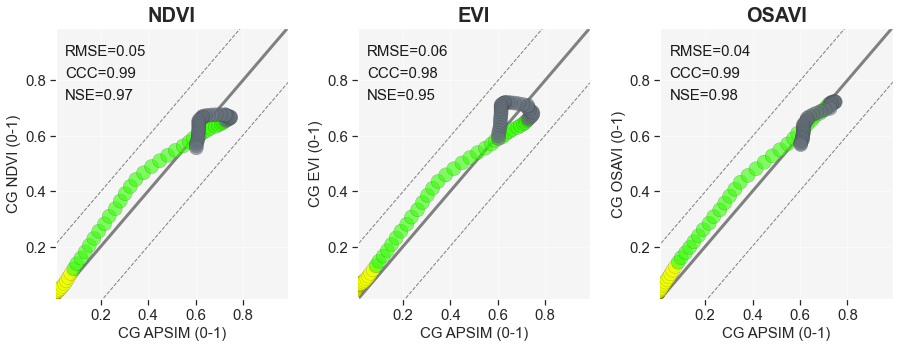

In [115]:
thres1=30
thres2=60
par['Das_Cluster']='30-60'
par['Das_Cluster'][par["Das"]<thres1]='0-30'
par['Das_Cluster'][par["Das"]>thres2]='60-103'
ndre['Das_Cluster']='30-60'
ndre['Das_Cluster'][ndre["Das"]<thres1]='0-30'
ndre['Das_Cluster'][ndre["Das"]>thres2]='60-103'

colors=['#F0FF00','#33FF00','#66717B'] #'#00B4FF','#FF0027','#CA00FF', '#BC45F8'
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(15,5))

################################################################################################
ax=plt.subplot(1, 3, 1)
ax.set_title('NDVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="NDVI_CG",hue='Das_Cluster' , alpha=0.6, data=df2, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('CG NDVI (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df2.NDVI_CG.values)
y_o= Obs.tolist()
Pre = pd.Series(df2.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

#########################################################
ax=plt.subplot(1, 3, 2)
ax.set_title('EVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="EVI_CG",hue='Das_Cluster' , alpha=0.6, data=df2, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('CG EVI (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df2.EVI_CG.values)
y_o= Obs.tolist()
Pre = pd.Series(df2.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')


#########################################################
ax=plt.subplot(1, 3, 3)
ax.set_title('OSAVI',fontsize= 20,weight='bold') 
xmax=0.99
ymax=0.99
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(cover['Cover_APSIM'], cover['NDVI'], yerr = cover['CoverGreen_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Cover_APSIM", y="OSAVI_CG",hue='Das_Cluster' , alpha=0.6, data=df2, linewidth=0.2,**kwargs, zorder=3, s=200, palette=colors)

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('CG OSAVI (0-1)', fontsize =15)
plt.xlabel('CG APSIM (0-1)', fontsize =15)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df2.OSAVI_CG.values)
y_o= Obs.tolist()
Pre = pd.Series(df2.Cover_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

######################################################################################
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\XYCG2.png', dpi=300,bbox_inches='tight')
hide_toggle()

## LAI and Biomass  (3 cultivars * 2 reps)

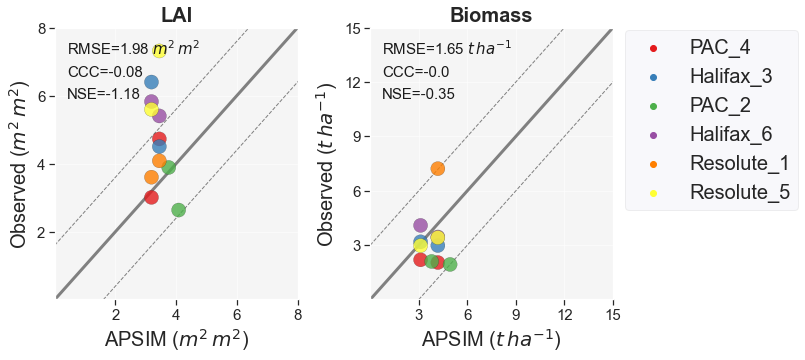

In [50]:
#Remove Nan to plot XY
cover = df[df['NDVI'].notna()]
lai = df[df['LAI_OBS'].notna()]
biomass = df[df['Biomass_OBS'].notna()]

#color_dict = dict({'Resolute_1': '#ff0101','PAC_2':'#0000fe','Halifax_3':'#00ff01','PAC_4':'#FC33FF','Resolute_5': '#00F9FF', 'Halifax_6':'F0FF00'})

kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(10,5))

################################################################################################
ax=plt.subplot(1, 2, 1)
ax.set_title('LAI',fontsize= 20,weight='bold') 
xmax=8
ymax=8
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(lai['LAI_APSIM'], lai['LAI_OBS'], yerr = lai['LAI_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="LAI_APSIM", y="LAI_OBS", hue='SN', alpha=0.8, data=lai, linewidth=0.2,**kwargs, zorder=3, s=200, palette='Set1')

# Formatting graph and background
plt.legend(prop=dict(size=10),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=2,framealpha=0.3)
plt.ylabel('Observed ($m^{2}\,m^{2}$)', fontsize =20)
plt.xlabel('APSIM ($m^{2}\,m^{2}$)', fontsize =20)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(lai.LAI_OBS.values)
y_o= Obs.tolist()
Pre = pd.Series(lai.LAI_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $m^{2}\,m^{2}$', fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

################################################################################################
ax=plt.subplot(1, 2, 2)
ax.set_title('Biomass',fontsize= 20,weight='bold') 
xmax=15
ymax=15
xmax20=xmax*0.2
plt.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20, ymax+xmax20],"--",color="grey", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="grey", linewidth=1,zorder=1)
#ax.errorbar(biomass['Biomass_APSIM'], biomass['Biomass_OBS'], yerr = biomass['Biomass_OBSError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="Biomass_APSIM", y="Biomass_OBS", hue='SN', alpha=0.8, data=biomass, linewidth=0.2,**kwargs, zorder=3, s=200, palette='Set1')

# Formatting graph and background
plt.legend(prop=dict(size=20),bbox_to_anchor=(1.05, 0.99), loc=2, borderaxespad=0., ncol=1,framealpha=0.3)
plt.ylabel('Observed ($t\,ha^{-1}$)', fontsize =20)
plt.xlabel('APSIM ($t\,ha^{-1}$)', fontsize =20)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list
Obs = pd.Series(biomass.Biomass_OBS.values)
y_o= Obs.tolist()
Pre = pd.Series(biomass.Biomass_APSIM.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

plt.text(xmax*0.05, ymax*0.9,'RMSE='+RMSE+' $t\,ha^{-1}$', fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.82,'CCC='+CCC, fontsize=15,color='k')
plt.text(xmax*0.05, ymax*0.74,'NSE='+NSE, fontsize=15,color='k')

######################################################################################
plt.subplots_adjust(wspace=0.3, hspace=0)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\CropPhen\figs\BIOMASSLAI.png', dpi=300,bbox_inches='tight')
hide_toggle()